In [1]:
import gymnasium as gym
import utils
from experiments import *
from typing import Literal

In [2]:
class ActorCriticLossMaxMax:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        batch_size: int,
        gamma: float = 0.9,
        num_next_state_sample: int = 10,
        next_state_sample: Literal["quantile", "gaussian", "null"] = "quantile",
        rollout_depth: int = 0,
        use_min: bool = False,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.gamma = gamma
        self.num_next_state_sample = num_next_state_sample
        self.next_state_sample = next_state_sample
        self.rollout_depth = rollout_depth
        self.use_min = use_min

        # Reward model R(s,s')
        self.reward_model = RewardModel(state_dim).to(DEVICE)
        self.reward_opt = optim.Adam(self.reward_model.parameters(), lr=1e-3)

        # Next-state predictors (only needed if rollout_depth>0)
        if next_state_sample == "quantile":
            self.quantile_models = EnsembleQuantileModels(
                state_dim, action_dim, quantiles=[0.05, 0.95], hidden_dim=128
            ).to(DEVICE)
            self.quantile_opts = [
                optim.Adam(m.parameters(), lr=1e-3) for m in self.quantile_models.models
            ]
        elif next_state_sample == "gaussian":
            self.next_state_model = MeanStdPredictor(
                state_dim, action_dim, hidden_dim=128
            ).to(DEVICE)
            self.next_state_opt = optim.Adam(
                self.next_state_model.parameters(), lr=1e-3
            )
        # else: "null" → no predictor at all

    def compute_yj(
        self,
        states: torch.Tensor,  # (bs, state_dim)
        actions: torch.Tensor,
        next_states: torch.Tensor,  # (bs, state_dim)
        target_actor: nn.Module,
        target_critic: nn.Module,
        rewards: torch.Tensor,  # (bs,1)
        dones: torch.Tensor,  # (bs,1)
    ) -> torch.Tensor:
        """
        Returns Y of shape (bs, N, 1) where
        N = 1 if rollout_depth==0, else num_next_state_sample.
        y_j^{(0)} uses the recorded (next_states, rewards).
        Later steps use the learned generator and reward model.
        """
        bs = states.size(0)
        gamma = self.gamma

        # --- Step 0: recorded next-state & reward ---
        with torch.no_grad():
            a_next = target_actor(next_states)  # (bs,action_dim)
            q_next = target_critic(next_states, a_next).unsqueeze(-1)  # (bs,1,1)
        y0 = rewards + gamma * (1 - dones) * q_next  # (bs,1,1)

        # If no deeper rollout, return y0
        if self.rollout_depth == 0 or self.next_state_sample == "null":
            return y0  # shape (bs,1,1)

        # --- Deeper rollouts start from the recorded next_states ---
        N = self.num_next_state_sample
        # Initialize: cur_states = [next_states] × N
        cur_states = next_states.unsqueeze(1).expand(bs, N, self.state_dim)
        # y carries forward; start by broadcasting y0 to shape (bs,N,1)
        cur_y = y0.expand(bs, N, 1)

        # Train predictor on the real data once
        if self.next_state_sample == "quantile":
            for tau, m, opt in zip(
                self.quantile_models.quantiles,
                self.quantile_models.models,
                self.quantile_opts,
            ):
                q_hat = m(states, actions)
                loss_q = quantile_loss(q_hat, next_states, tau=tau)
                opt.zero_grad()
                loss_q.backward()
                opt.step()
        else:  # gaussian
            mu, std = self.next_state_model(states, actions)
            loss_g = gaussian_std_nll_loss(mu, std, next_states)
            self.next_state_opt.zero_grad()
            loss_g.backward()
            self.next_state_opt.step()

        # --- Perform rollout_depth steps ---
        if random.random() < 0.1: 
            rollout_depth = self.rollout_depth
        else: rollout_depth = 0
        for _ in range(rollout_depth):
            # flatten for model calls
            flat_s = cur_states.reshape(bs * N, self.state_dim)
            # 1) policy & critic for next-actions
            a_k = target_actor(flat_s)
            # 2) generate new next-states
            if self.next_state_sample == "quantile":
                ql, qu = self.quantile_models(flat_s, a_k)
                eps = torch.rand_like(ql)
                flat_nxt = (1 - eps) * ql + eps * qu
            else:  # gaussian
                mu, std = self.next_state_model(flat_s, a_k)
                flat_nxt = mu + std * torch.randn_like(std)
            # 3) learned reward R(s_k, s_{k+1})
            r_k = self.reward_model(flat_s, flat_nxt)
            # 4) flatten cur_y
            flat_y = cur_y.reshape(bs * N, 1)
            # 5) one Bellman step on imagined
            flat_y = r_k + gamma * flat_y
            # 6) prepare for next iter
            cur_y = flat_y.view(bs, N, 1)
            cur_states = flat_nxt.view(bs, N, self.state_dim).detach()

        return cur_y  # (bs, N, 1)

    def __call__(
        self,
        replay_buffer,
        online_actor,
        target_actor,
        actor_optimizer,
        online_critic,
        target_critic,
        critic_optimizer,
        **kwargs,
    ):
        if len(replay_buffer) < self.batch_size:
            return None

        # -- 1) Sample a batch
        s, a, r, s_next, done = replay_buffer.sample(self.batch_size)
        states = torch.FloatTensor(s).to(DEVICE)
        actions = torch.FloatTensor(a).to(DEVICE)
        rewards = torch.FloatTensor(r).unsqueeze(-1).to(DEVICE)
        next_states = torch.FloatTensor(s_next).to(DEVICE)
        dones = torch.FloatTensor(done).unsqueeze(-1).to(DEVICE)

        # -- 2) Train reward model on real (s,s')
        r_pred = self.reward_model(states, next_states)
        loss_r = F.mse_loss(r_pred, rewards)
        self.reward_opt.zero_grad()
        loss_r.backward()
        self.reward_opt.step()

        # -- 3) Compute roll‑out targets
        Y = self.compute_yj(
            actions, states, next_states, target_actor, target_critic, rewards, dones
        )
        # Y: (bs, N, 1)
        if self.use_min:
            Y_agg, _ = torch.min(Y, dim=1)  # (bs,1)
        else:
            Y_agg, _ = torch.max(Y, dim=1)  # (bs,1)

        # -- 4) Critic update
        target_q = rewards + self.gamma * (1 - dones) * Y_agg.detach()
        current_q = online_critic(states, actions)
        loss_c = F.mse_loss(current_q, target_q)
        critic_optimizer.zero_grad()
        loss_c.backward()
        critic_optimizer.step()

        # -- 5) Actor update
        loss_a = -online_critic(states, online_actor(states)).mean()
        actor_optimizer.zero_grad()
        loss_a.backward()
        actor_optimizer.step()

        return loss_a

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Literal

# Placeholder imports—assume these are defined elsewhere:
#   RewardModel, EnsembleQuantileModels, MeanStdPredictor
#   quantile_loss, sample_candidates_unif, sample_candidates_gaussian
#   gaussian_std_nll_loss

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ActorCriticLossMaxMax2:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        batch_size: int,
        gamma: float = 0.9,
        num_next_state_sample: int = 10,
        next_state_sample: Literal["quantile", "gaussian", "null"] = "quantile",
        rollout_depth: int = 0,
        use_min: bool = False,
    ):
        self.state_dim  = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.gamma      = gamma
        self.num_next_state_sample = num_next_state_sample
        self.next_state_sample = next_state_sample
        self.rollout_depth = rollout_depth
        self.use_min    = use_min

        # Reward model R(s, s')
        self.reward_model = RewardModel(state_dim).to(DEVICE)
        self.reward_opt   = optim.Adam(self.reward_model.parameters(), lr=1e-3)

        # Next-state predictors (only if rollout_depth > 0)
        if next_state_sample == "quantile":
            self.quantile_models = EnsembleQuantileModels(
                state_dim, action_dim, quantiles=[0.05, 0.95], hidden_dim=128
            ).to(DEVICE)
            self.quantile_opts = [
                optim.Adam(m.parameters(), lr=1e-3)
                for m in self.quantile_models.models
            ]
        elif next_state_sample == "gaussian":
            self.next_state_model = MeanStdPredictor(
                state_dim, action_dim, hidden_dim=128
            ).to(DEVICE)
            self.next_state_opt   = optim.Adam(
                self.next_state_model.parameters(), lr=1e-3
            )
        # else: "null" → no predictor at all

    def compute_yj(
        self,
        states: torch.Tensor,       # (bs, state_dim)
        actions: torch.Tensor,      # (bs, action_dim)
        next_states: torch.Tensor,  # (bs, state_dim)
        target_actor: nn.Module,
        target_critic: nn.Module,
        rewards: torch.Tensor,      # (bs, 1)
        dones: torch.Tensor,        # (bs, 1)
    ) -> torch.Tensor:
        """
        Returns Y of shape (bs, N, 1) where
        N = 1 if rollout_depth==0 or next_state_sample=="null",
        else num_next_state_sample.
        """

        bs = states.size(0)
        gamma = self.gamma

        # --- Step 0: use recorded next-state & reward ---
        with torch.no_grad():
            a_next = target_actor(next_states)                   # (bs, action_dim)
            q_next = target_critic(next_states, a_next)          # (bs, 1)
        # unsqueeze to (bs,1,1) for uniform interface
        y0 = (rewards + gamma * (1 - dones) * q_next).unsqueeze(1)

        # if no rollout, return y0 directly
        if self.rollout_depth == 0 or self.next_state_sample == "null":
            return y0  # shape (bs,1,1)

        # --- deeper rollouts start from recorded next_states ---
        N = self.num_next_state_sample
        cur_states = next_states.unsqueeze(1).expand(bs, N, self.state_dim)  # (bs,N,D)
        cur_y      = y0.expand(bs, N, 1)                                     # (bs,N,1)

        # train predictor once
        if self.next_state_sample == "quantile":
            for tau, m, opt in zip(
                self.quantile_models.quantiles,
                self.quantile_models.models,
                self.quantile_opts,
            ):
                q_hat = m(states, actions)
                loss_q = quantile_loss(q_hat, next_states, tau=tau)
                opt.zero_grad(); loss_q.backward(); opt.step()
        else:  # gaussian
            mu, std = self.next_state_model(states, actions)
            loss_g  = gaussian_std_nll_loss(mu, std, next_states)
            self.next_state_opt.zero_grad(); loss_g.backward(); self.next_state_opt.step()

        # rollout loop
        for _ in range(self.rollout_depth):
            flat_s = cur_states.reshape(bs * N, self.state_dim)       # (bs*N, D)
            a_k    = target_actor(flat_s)                             # (bs*N, A)

            if self.next_state_sample == "quantile":
                ql, qu = self.quantile_models(flat_s, a_k)
                eps     = torch.rand_like(ql)
                flat_nxt = (1 - eps) * ql + eps * qu
            else:  # gaussian
                mu, std  = self.next_state_model(flat_s, a_k)
                flat_nxt = mu + std * torch.randn_like(std)

            # learned reward R(s_k, s_{k+1})
            r_k = self.reward_model(flat_s, flat_nxt)                 # (bs*N,1)
            flat_y = cur_y.reshape(bs * N, 1)                         # (bs*N,1)
            flat_y = r_k + gamma * flat_y                             # (bs*N,1)

            cur_y      = flat_y.view(bs, N, 1)                        # (bs,N,1)
            cur_states = flat_nxt.view(bs, N, self.state_dim).detach()

        return cur_y  # (bs, N, 1)

    def __call__(
        self,
        replay_buffer,
        online_actor,
        target_actor,
        actor_optimizer,
        online_critic,
        target_critic,
        critic_optimizer,
        **kwargs,
    ):
        if len(replay_buffer) < self.batch_size:
            return None

        # 1) Sample batch
        s, a, r, s_next, done = replay_buffer.sample(self.batch_size)
        states      = torch.FloatTensor(s).to(DEVICE)
        actions     = torch.FloatTensor(a).to(DEVICE)
        rewards     = torch.FloatTensor(r).unsqueeze(-1).to(DEVICE)
        next_states = torch.FloatTensor(s_next).to(DEVICE)
        dones       = torch.FloatTensor(done).unsqueeze(-1).to(DEVICE)

        # 2) Train reward model on real (s,s')
        r_pred = self.reward_model(states, next_states)
        loss_r = F.mse_loss(r_pred, rewards)
        self.reward_opt.zero_grad()
        loss_r.backward()
        self.reward_opt.step()

        # 3) Compute roll‑out targets
        Y = self.compute_yj(
            states, actions, next_states,
            target_actor, target_critic,
            rewards, dones
        )
        # Y: (bs, N, 1)
        if self.use_min:
            Y_agg, _ = torch.min(Y, dim=1)  # (bs,1)
        else:
            Y_agg, _ = torch.max(Y, dim=1)  # (bs,1)

        # 4) Critic update
        target_q   = rewards + self.gamma * (1 - dones) * Y_agg.detach()
        current_q  = online_critic(states, actions)
        loss_c     = F.mse_loss(current_q, target_q)
        critic_optimizer.zero_grad()
        loss_c.backward()
        critic_optimizer.step()

        # 5) Actor update
        loss_a = -online_critic(states, online_actor(states)).mean()
        actor_optimizer.zero_grad()
        loss_a.backward()
        actor_optimizer.step()

        return loss_a


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Literal

# Placeholder imports—assume these are defined elsewhere:
#   RewardModel, EnsembleQuantileModels, MeanStdPredictor
#   quantile_loss, sample_candidates_unif, sample_candidates_gaussian
#   gaussian_std_nll_loss

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ActorCriticLossMaxMax2_zerograd:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        batch_size: int,
        gamma: float = 0.9,
        num_next_state_sample: int = 10,
        next_state_sample: Literal["quantile", "gaussian", "null"] = "quantile",
        rollout_depth: int = 0,
        use_min: bool = False,
        prob_rollout: float = 0.1
    ):
        self.state_dim  = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.gamma      = gamma
        self.num_next_state_sample = num_next_state_sample
        self.next_state_sample = next_state_sample
        self.rollout_depth = rollout_depth
        self.prob_rollout =prob_rollout
        self.use_min    = use_min

        # Reward model R(s, s')
        self.reward_model = RewardModel(state_dim).to(DEVICE)
        self.reward_opt   = optim.Adam(self.reward_model.parameters(), lr=1e-3)

        # Next-state predictors (only if rollout_depth > 0)
        if next_state_sample == "quantile":
            self.quantile_models = EnsembleQuantileModels(
                state_dim, action_dim, quantiles=[0.05, 0.95], hidden_dim=128
            ).to(DEVICE)
            self.quantile_opts = [
                optim.Adam(m.parameters(), lr=1e-3)
                for m in self.quantile_models.models
            ]
        elif next_state_sample == "gaussian":
            self.next_state_model = MeanStdPredictor(
                state_dim, action_dim, hidden_dim=128
            ).to(DEVICE)
            self.next_state_opt   = optim.Adam(
                self.next_state_model.parameters(), lr=1e-3
            )
        # else: "null" → no predictor at all

    def compute_yj(
        self,
        states: torch.Tensor,       # (bs, state_dim)
        actions: torch.Tensor,      # (bs, action_dim)
        next_states: torch.Tensor,  # (bs, state_dim)
        target_actor: nn.Module,
        target_critic: nn.Module,
        rewards: torch.Tensor,      # (bs, 1)
        dones: torch.Tensor,        # (bs, 1)
    ) -> torch.Tensor:
        """
        Returns Y of shape (bs, N, 1) where
        N = 1 if rollout_depth==0 or next_state_sample=="null",
        else num_next_state_sample.
        """

        bs = states.size(0)
        gamma = self.gamma

        # --- Step 0: use recorded next-state & reward ---
        with torch.no_grad():
            a_next = target_actor(next_states)                   # (bs, action_dim)
            q_next = target_critic(next_states, a_next)          # (bs, 1)
        # unsqueeze to (bs,1,1) for uniform interface
        y0 = (rewards + gamma * (1 - dones) * q_next).unsqueeze(1)

        # if no rollout, return y0 directly
        if self.rollout_depth == 0 or self.next_state_sample == "null":
            return y0  # shape (bs,1,1)

        # --- deeper rollouts start from recorded next_states ---
        N = self.num_next_state_sample
        cur_states = next_states.unsqueeze(1).expand(bs, N, self.state_dim)  # (bs,N,D)
        cur_y      = y0.expand(bs, N, 1)                                     # (bs,N,1)

        # train predictor once
        if self.next_state_sample == "quantile":
            for tau, m, opt in zip(
                self.quantile_models.quantiles,
                self.quantile_models.models,
                self.quantile_opts,
            ):
                q_hat = m(states, actions)
                loss_q = quantile_loss(q_hat, next_states, tau=tau)
                opt.zero_grad(); loss_q.backward(); opt.step()
        else:  # gaussian
            mu, std = self.next_state_model(states, actions)
            loss_g  = gaussian_std_nll_loss(mu, std, next_states)
            self.next_state_opt.zero_grad(); loss_g.backward(); self.next_state_opt.step()

        # rollout loop
        rollout_depth = 0
        with torch.no_grad():
            for _ in range(rollout_depth):
                flat_s = cur_states.reshape(bs * N, self.state_dim)       # (bs*N, D)
                a_k    = target_actor(flat_s)                             # (bs*N, A)
    
                if self.next_state_sample == "quantile":
                    ql, qu = self.quantile_models(flat_s, a_k)
                    eps     = torch.rand_like(ql)
                    flat_nxt = (1 - eps) * ql + eps * qu
                else:  # gaussian
                    mu, std  = self.next_state_model(flat_s, a_k)
                    flat_nxt = mu + std * torch.randn_like(std)
    
                # learned reward R(s_k, s_{k+1})
                r_k = self.reward_model(flat_s, flat_nxt)                 # (bs*N,1)
                flat_y = cur_y.reshape(bs * N, 1)                         # (bs*N,1)
                flat_y = r_k + gamma * flat_y                             # (bs*N,1)
    
                cur_y      = flat_y.view(bs, N, 1)                        # (bs,N,1)
                cur_states = flat_nxt.view(bs, N, self.state_dim).detach()

        return cur_y  # (bs, N, 1)

    def __call__(
        self,
        replay_buffer,
        online_actor,
        target_actor,
        actor_optimizer,
        online_critic,
        target_critic,
        critic_optimizer,
        **kwargs,
    ):
        if len(replay_buffer) < self.batch_size:
            return None

        # 1) Sample batch
        s, a, r, s_next, done = replay_buffer.sample(self.batch_size)
        states      = torch.FloatTensor(s).to(DEVICE)
        actions     = torch.FloatTensor(a).to(DEVICE)
        rewards     = torch.FloatTensor(r).unsqueeze(-1).to(DEVICE)
        next_states = torch.FloatTensor(s_next).to(DEVICE)
        dones       = torch.FloatTensor(done).unsqueeze(-1).to(DEVICE)

        # 2) Train reward model on real (s,s')
        r_pred = self.reward_model(states, next_states)
        loss_r = F.mse_loss(r_pred, rewards)
        self.reward_opt.zero_grad()
        loss_r.backward()
        self.reward_opt.step()

        # 3) Compute roll‑out targets
        Y = self.compute_yj(
            states, actions, next_states,
            target_actor, target_critic,
            rewards, dones
        )
        # Y: (bs, N, 1)
        if self.use_min:
            Y_agg, _ = torch.min(Y, dim=1)  # (bs,1)
        else:
            Y_agg, _ = torch.max(Y, dim=1)  # (bs,1)

        # 4) Critic update
        target_q   = rewards + self.gamma * (1 - dones) * Y_agg.detach()
        current_q  = online_critic(states, actions)
        loss_c     = F.mse_loss(current_q, target_q)
        critic_optimizer.zero_grad()
        loss_c.backward()
        critic_optimizer.step()

        # 5) Actor update
        loss_a = -online_critic(states, online_actor(states)).mean()
        actor_optimizer.zero_grad()
        loss_a.backward()
        actor_optimizer.step()

        return loss_a


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Literal

# Placeholder imports; replace these with your actual implementations:
# from your_models import RewardModel, EnsembleQuantileModels, MeanStdPredictor
# from your_losses import quantile_loss, gaussian_std_nll_loss
# from your_samplers import sample_candidates_unif, sample_candidates_gaussian

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ActorCriticLossMaxMaxFix:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        batch_size: int,
        gamma: float = 0.9,
        num_next_state_sample: int = 10,
        next_state_sample: Literal["quantile", "gaussian", "null"] = "quantile",
        rollout_depth: int = 0,             # only 0 or 1 supported
        use_min: bool = False,
        rollout_prob: float = 0.1
    ):
        assert rollout_depth in (0, 1), "Only rollout_depth=0 or 1 supported"
        self.state_dim  = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.gamma      = gamma
        self.next_state_sample  = next_state_sample
        self.rollout_depth      = rollout_depth
        self.use_min           = use_min
        self.num_next_state_sample = num_next_state_sample
        self.rollout_prob = 1-rollout_prob
        # 1) Learned reward model R(s, s')
        self.reward_model = RewardModel(state_dim).to(DEVICE)
        self.reward_opt   = optim.Adam(self.reward_model.parameters(), lr=1e-3)
        

        # 2) Imagination model (only if rollout_depth=1 and not "null")
        if rollout_depth == 1 and next_state_sample == "quantile":
            self.quantile_models = EnsembleQuantileModels(
                state_dim, action_dim, quantiles=[0.05, 0.95], hidden_dim=128
            ).to(DEVICE)
            self.quantile_opts = [
                optim.Adam(m.parameters(), lr=1e-3)
                for m in self.quantile_models.models
            ]
        elif rollout_depth == 1 and next_state_sample == "gaussian":
            self.next_state_model = MeanStdPredictor(
                state_dim, action_dim, hidden_dim=128
            ).to(DEVICE)
            self.next_state_opt   = optim.Adam(
                self.next_state_model.parameters(), lr=1e-3
            )
        # else: no predictor needed for depth=0 or "null"

    def compute_yj(
        self,
        states:      torch.Tensor,  # (bs, state_dim)
        actions:     torch.Tensor,  # (bs, action_dim)
        next_states: torch.Tensor,  # (bs, state_dim)
        target_actor: nn.Module,
        target_critic: nn.Module,
        rewards:     torch.Tensor,  # (bs,1)
        dones:       torch.Tensor,  # (bs,1)
    ) -> torch.Tensor:
        bs = states.size(0)
        γ  = self.gamma

        # --- Step 0: Standard TD(0) bootstrap on recorded transition ---
        with torch.no_grad():
            a1 = target_actor(next_states)                 # (bs, A)
            q1 = target_critic(next_states, a1)             # (bs, 1)
        # shape (bs, 1, 1)
        y0 = (rewards + γ * (1 - dones) * q1).unsqueeze(1)

        if self.rollout_depth == 0 or self.next_state_sample == "null":
            return y0                                                    # (bs,1,1)

        # --- Now rollout_depth == 1 and next_state_sample != "null" ---
        # Train the imagination model on real data:
        if self.next_state_sample == "quantile":
            for τ, m, opt in zip(
                self.quantile_models.quantiles,
                self.quantile_models.models,
                self.quantile_opts
            ):
                q_hat = m(states, actions)
                loss_q = quantile_loss(q_hat, next_states, tau=τ)
                opt.zero_grad(); loss_q.backward(); opt.step()
        else:  # gaussian
            mu, std = self.next_state_model(states, actions)
            loss_g  = gaussian_std_nll_loss(mu, std, next_states)
            self.next_state_opt.zero_grad(); loss_g.backward(); self.next_state_opt.step()
            
        if random.random() < self.rollout_prob: return y0
        # --- One imagined step (all in no_grad) ---
        with torch.no_grad():
            # expand recorded next_state s1 to shape (bs, N, D)
            N = self.num_next_state_sample
            s1 = next_states.unsqueeze(1).expand(bs, N, self.state_dim)  # (bs,N,D)
            a1_rep = target_actor(s1.reshape(-1, self.state_dim))       # (bs*N, A)

            # generate s2 candidates
            if self.next_state_sample == "quantile":
                ql, qu = self.quantile_models(
                    s1.reshape(-1, self.state_dim),
                    a1_rep
                )
                eps    = torch.rand_like(ql)
                s2_flat= (1 - eps) * ql + eps * qu
            else:  # gaussian
                mu, std   = self.next_state_model(
                    s1.reshape(-1, self.state_dim),
                    a1_rep
                )
                s2_flat   = mu + std * torch.randn_like(std)

            # reshape s2_flat → (bs, N, D)
            s2 = s2_flat.view(bs, N, self.state_dim)

            # learned reward R(s1, s2)
            r1 = self.reward_model(
                s1.reshape(-1, self.state_dim),
                s2_flat
            ).view(bs, N, 1)

            # Q(s2, μ(s2))
            a2 = target_actor(s2_flat)                                     # (bs*N, A)
            q2 = target_critic(s2_flat, a2).view(bs, N, 1)                 # (bs,N,1)

            # one imagined Bellman step: R + γ Q
            imag_term = r1 + γ * q2                                       # (bs,N,1)

        # final y1: r0 + γ * imag_term  => r0 + γ*R + γ^2 Q
        y1 = rewards.unsqueeze(1) + γ * imag_term                        # (bs,N,1)

        return y1

    def __call__(
        self,
        replay_buffer,
        online_actor,
        target_actor,
        actor_optimizer,
        online_critic,
        target_critic,
        critic_optimizer,
        **kwargs,
    ):
        if len(replay_buffer) < self.batch_size:
            return None

        # 1) sample batch
        s, a, r, s_next, done = replay_buffer.sample(self.batch_size)
        states      = torch.FloatTensor(s).to(DEVICE)
        actions     = torch.FloatTensor(a).to(DEVICE)
        rewards     = torch.FloatTensor(r).unsqueeze(-1).to(DEVICE)
        next_states = torch.FloatTensor(s_next).to(DEVICE)
        dones       = torch.FloatTensor(done).unsqueeze(-1).to(DEVICE)

        # 2) train reward model on real (s,s')
        r_pred = self.reward_model(states, next_states)
        loss_r = F.mse_loss(r_pred, rewards)
        self.reward_opt.zero_grad(); loss_r.backward(); self.reward_opt.step()

        # 3) compute y_j (0 or 1 step)
        Y = self.compute_yj(
            states, actions, next_states,
            target_actor, target_critic,
            rewards, dones
        )
        # Y.shape = (bs, N, 1)
        if self.use_min:
            Y_agg, _ = torch.min(Y, dim=1)  # (bs,1)
        else:
            Y_agg, _ = torch.max(Y, dim=1)  # (bs,1)

        # 4) critic update
        target_q   = Y_agg.detach()
        current_q  = online_critic(states, actions)
        loss_c     = F.mse_loss(current_q, target_q)
        critic_optimizer.zero_grad(); loss_c.backward(); critic_optimizer.step()

        # 5) actor update
        loss_a = -online_critic(states, online_actor(states)).mean()
        actor_optimizer.zero_grad(); loss_a.backward(); actor_optimizer.step()

        return loss_a


In [5]:
class BasicActorCriticLoss:           # << drop‑in replacement
    def __init__(
        self,
        state_dim:  int,
        action_dim: int,
        batch_size: int,
        gamma: float                = 0.99,
        # the next 3 kwargs are accepted for API‑compat but unused
        **kwargs, 
    ):
        self.batch_size = batch_size
        self.gamma      = gamma

    # ------------------------------------------------------------------ #
    # compute_yj  — trivial one‑step target                               #
    # ------------------------------------------------------------------ #
    @staticmethod
    def compute_y(
        rewards: torch.Tensor,      # (bs,1)
        dones:   torch.Tensor,      # (bs,1)
        next_states: torch.Tensor,  # (bs,D)
        target_actor:  nn.Module,
        target_critic: nn.Module,
        gamma: float,
    ) -> torch.Tensor:              # returns (bs,1)
        with torch.no_grad():
            next_actions = target_actor(next_states)
            q_next       = target_critic(next_states, next_actions)
        return rewards + gamma * (1 - dones) * q_next

    # ------------------------------------------------------------------ #
    #  main callable                                                     #
    # ------------------------------------------------------------------ #
    def __call__(
        self,
        replay_buffer,
        online_actor,
        target_actor,
        actor_optimizer,
        online_critic,
        target_critic,
        critic_optimizer,
        **kwargs,                   # keeps compatibility
    ):
        if len(replay_buffer) < self.batch_size:
            return None

        s, a, r, s_next, done = replay_buffer.sample(self.batch_size)
        states      = torch.FloatTensor(s).to(DEVICE)
        actions     = torch.FloatTensor(a).to(DEVICE)
        rewards     = torch.FloatTensor(r).unsqueeze(-1).to(DEVICE)
        next_states = torch.FloatTensor(s_next).to(DEVICE)
        dones       = torch.FloatTensor(done).unsqueeze(-1).to(DEVICE)

        # ------ Critic update ------------------------------------------
        target_q = self.compute_y(
            rewards, dones, next_states, target_actor, target_critic, self.gamma
        )
        current_q = online_critic(states, actions)
        critic_loss = F.mse_loss(current_q, target_q.detach())
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # ------ Actor update -------------------------------------------
        actor_loss = -online_critic(states, online_actor(states)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        return actor_loss


In [32]:
env = gym.make("HalfCheetah-v5")

# env: gym.Env = gym.make(env_name, render_mode="rgb_array")
# env: gym.Env = gym.make(env_name, render_mode="rgb_array")
experimental_results = {}

next_state_sample = "quantile"
[
    "null",
    "gaussian",
    "triangular",
    "unif",
]
    
replay_buffer = ReplayBuffer(capacity=100000)

state_dim: int = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

online_actor = Actor(state_dim, action_dim).to(DEVICE)
online_critic = SimpleCritic(state_dim, action_dim).to(DEVICE)
target_actor = Actor(state_dim, action_dim).to(DEVICE)
target_critic = SimpleCritic(state_dim, action_dim).to(DEVICE)
target_actor.load_state_dict(online_actor.state_dict())
target_critic.load_state_dict(online_critic.state_dict())

actor_optimizer = optim.Adam(online_actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(online_critic.parameters(), lr=1e-3)

select_action_func = AC_SelectAction(action_dim=action_dim)
# loss_func = actor_critic_loss(
#     state_dim=state_dim,
#     action_dim=action_dim,
#     batch_size=256,
#     gamma=0.99,
#
# )
#BasicActorCriticLoss
loss_func = ActorCriticLossMaxMaxFix(
    state_dim=state_dim,
    action_dim=action_dim,
    batch_size=256,
    gamma=0.99,
    num_next_state_sample=5,
    next_state_sample=next_state_sample,
    rollout_depth = 1, 
    use_min=False, 
    rollout_prob= 0.1
)
configs = {
    "action_dim": action_dim,
    "state_dim": state_dim,
    "episodes": 1000,
    "eps": 0.1,
    "tau_soft_update": 0.1,
    "update_per_step": 500
}

rewards = training_loop_ac(
    env=env,
    replay_buffer = replay_buffer, 
    select_action_func=select_action_func,
    loss_func=loss_func,
    online_actor=online_actor,
    target_actor=target_actor,
    actor_optimizer=actor_optimizer,
    online_critic=online_critic,
    target_critic=target_critic,
    critic_optimizer=critic_optimizer,
    configs=configs,
    print_info=True
)


Episode: 0 | Reward: -51765.648623962756
Episode: 1 | Reward: -158873.67898913412
Episode: 2 | Reward: -162745.0053222415
Episode: 3 | Reward: -194385.6358455707
Episode: 4 | Reward: -139621.8482559711
Episode: 5 | Reward: -161112.88940771107
Episode: 6 | Reward: -147433.28727376342
Episode: 7 | Reward: -138972.98725709203
Episode: 8 | Reward: -87407.12910514825
Episode: 9 | Reward: -68614.70598455299
Episode: 10 | Reward: -92588.39874535092
Episode: 11 | Reward: -90736.10590098084
Episode: 12 | Reward: -49193.62695192215
Episode: 13 | Reward: -48693.343858697626
Episode: 14 | Reward: -29581.719317372663
Episode: 15 | Reward: -33435.485509919476
Episode: 16 | Reward: -32157.778984706194
Episode: 17 | Reward: -33230.56900132549
Episode: 18 | Reward: -32121.61699370192
Episode: 19 | Reward: -29882.437658422154
Episode: 20 | Reward: -28353.796912917915
Episode: 21 | Reward: -22537.704707064993
Episode: 22 | Reward: -18022.793542444488
Episode: 23 | Reward: -18322.580016627184
Episode: 24 

In [33]:
def maxmax_experiment(
    env_name: str,
    episodes: int,
    num_ensemble: int = 5,
    hidden_dim: int = 64,
    num_runs: int = 2,
    GAMMA: float = 0.99,
    batch_size: int = 128,
) -> dict:
    """
    Runs max-max actor-critic experiments over:
      - next_state_sample in ["null", "gaussian", "quantile"]
      - rollout_prob in [0.1, 0.5, 0.9] (ignored for "null")
    Each combination is run `num_runs` times.
    Uses 150 update steps/episode for "null" and 500 for the others.
    """
    results = {}

    for mode in ["null", "gaussian", "quantile"]:
        if mode == "null":
            probs = [None]  # no rollout_prob
        else:
            probs = [0.1, 0.5, 0.9]

        for p in probs:
            # build a descriptive name
            name = mode if p is None else f"{mode}_{p}"
            all_rewards = []

            for run in range(num_runs):
                print(f"Run [{run+1}/{num_runs}] ─ mode={name}")

                # 1) env & replay buffer
                env = gym.make(env_name)
                buffer = ReplayBuffer(capacity=100_000)

                state_dim  = env.observation_space.shape[0]
                action_dim = env.action_space.shape[0]

                # 2) networks
                online_actor  = Actor(state_dim, action_dim).to(DEVICE)
                target_actor  = Actor(state_dim, action_dim).to(DEVICE)
                target_actor.load_state_dict(online_actor.state_dict())

                online_critic = SimpleCritic(state_dim, action_dim).to(DEVICE)
                target_critic = SimpleCritic(state_dim, action_dim).to(DEVICE)
                target_critic.load_state_dict(online_critic.state_dict())

                # 3) optimizers
                actor_opt  = optim.Adam(online_actor.parameters(), lr=1e-3)
                critic_opt = optim.Adam(online_critic.parameters(), lr=1e-3)

                # 4) loss function with rollout_prob p
                loss_fn = ActorCriticLossMaxMaxFix(
                    state_dim           = state_dim,
                    action_dim          = action_dim,
                    batch_size          = batch_size,
                    gamma               = GAMMA,
                    num_next_state_sample = 5,
                    next_state_sample   = mode,
                    rollout_depth       = 1 if mode != "null" else 0,
                    use_min             = False,
                    rollout_prob        = p or 0.0,
                )

                # 5) select-action fn
                select_action = AC_SelectAction(action_dim=action_dim)

                # 6) configs
                updates = 200 if mode == "null" else 500
                configs = {
                    "action_dim":        action_dim,
                    "state_dim":         state_dim,
                    "episodes":          episodes,
                    "batch_size":        batch_size,
                    "eps":               0.1,
                    "tau_soft_update":   0.1,
                    "updates_per_episode": updates,
                }

                # 7) train
                try:
                    rewards = training_loop_ac(
                    env=env,
                    replay_buffer=buffer,
                    select_action_func=select_action,
                    loss_func=loss_fn,
                    online_actor=online_actor,
                    target_actor=target_actor,
                    actor_optimizer=actor_opt,
                    online_critic=online_critic,
                    target_critic=target_critic,
                    critic_optimizer=critic_opt,
                    configs=configs,
                    print_info=False,
                    )
                    print(max(rewards))
                    all_rewards.append(rewards)
                except Exception as e:
                    print(e)

                env.close()

            results[name] = all_rewards

    return results

In [35]:
utils.log_results({1:2}, "fun")

In [34]:
maxmax_experiment("HalfCheetah-v5", 10)

Run [1/2] ─ mode=null
Run [2/2] ─ mode=null
Run [1/2] ─ mode=gaussian_0.1
Run [2/2] ─ mode=gaussian_0.1
Run [1/2] ─ mode=gaussian_0.5
Run [2/2] ─ mode=gaussian_0.5
Run [1/2] ─ mode=gaussian_0.9
Run [2/2] ─ mode=gaussian_0.9
Run [1/2] ─ mode=quantile_0.1
Run [2/2] ─ mode=quantile_0.1
Run [1/2] ─ mode=quantile_0.5
Run [2/2] ─ mode=quantile_0.5
Run [1/2] ─ mode=quantile_0.9
Run [2/2] ─ mode=quantile_0.9


{'null': [[np.float64(-68371.7639224661),
   np.float64(-148688.99018825864),
   np.float64(-110922.70736509962),
   np.float64(-95120.89987580842),
   np.float64(-41498.081706123936),
   np.float64(-232352.73174914304),
   np.float64(-164661.37239316423),
   np.float64(-583045.4116261726),
   np.float64(-333817.50323806045),
   np.float64(-251929.57669253237)],
  [np.float64(-61477.82932377105),
   np.float64(-50651.18754437658),
   np.float64(-43900.302508639856),
   np.float64(-94815.89428243789),
   np.float64(-64514.244929735636),
   np.float64(-22982.83802589384),
   np.float64(-9425.464747337357),
   np.float64(-4420.792901395391),
   np.float64(-4545.130699967365),
   np.float64(-4379.85261535067)]],
 'gaussian_0.1': [[np.float64(-14482.762788894548),
   np.float64(-1693.9695383187284),
   np.float64(-745.7672098082086),
   np.float64(-687.6129541959634),
   np.float64(-507.8966553048243),
   np.float64(-622.35253496032),
   np.float64(-387.8764258073804),
   np.float64(-289.96

In [ ]:
def mean_var_experiment(
    env, episodes, batch_size=256, hidden_dim=128, num_runs=1, GAMMA=0.99
) -> dict:
    state_dim: int = env.observation_space.shape[0]
    action_dim: int = env.action_space.n

    loss_functions = []
    action_selection_methods = []

    for beta in [-0.5, -0.25, 0, 0.25, 0.5]:
        action_selection_methods.append(
            (
                mean_logvar_actionselection(action_dim=action_dim, beta=beta),
                f"log_uncertainity_{beta}",
            )
        )

    action_selection_methods.append(
        (mean_logvar_maxexpected(action_dim=action_dim), "maxexpected")
    )

    loss_functions.append(
        (distributional_qn_loss(GAMMA=GAMMA, method="Dkl"), "dkl_loss")
    )
    loss_functions.append(
        (distributional_qn_loss(GAMMA=GAMMA, method="Wasserstein"), "wasserstein_loss")
    )
    experimental_results = {}

    configs = {
        "action_dim": action_dim,
        "state_dim": state_dim,
        "episodes": episodes,
        "gamma": GAMMA,
        "eps": 0.1,
        "tau_soft_update": 0.05,
        "update_steps": 1
    }
    for loss_function in loss_functions:
        for action_selection_method in action_selection_methods:
            name = f"{loss_function[1]}_{action_selection_method[1]}"
            results = []
            for exp_n in range(num_runs):
                print(name)
                online_network = MeanVarianceQNetwork(
                    state_dim=state_dim, action_dim=action_dim, hidden_dim=hidden_dim
                ).to(DEVICE)
                target_network = MeanVarianceQNetwork(
                    state_dim=state_dim, action_dim=action_dim, hidden_dim=hidden_dim
                ).to(DEVICE)
                hard_target_update(online_network, target_network)
                optimizers = optim.Adam(online_network.parameters(), lr=1e-3)
                replay_buffer = ReplayBuffer()
                try:
                    rewards = training_loop_qn(
                        env=env,
                        online_qnet=online_network,
                        target_qnet=target_network,
                        optimizers=optimizers,
                        td_lossfunc=loss_function[0],
                        select_action=action_selection_method[0],
                        replay_buffer=replay_buffer,
                        configs=configs,
                        print_info=False,
                        discrete=True,
                    )
                    results.append(rewards)
                except Exception as e:
                    print(e)
            experimental_results[name] = results
    return experimental_results


env = gym.make("CartPole-v1")
results = mean_var_experiment(env, episodes = 500, batch_size = 64)

In [8]:
results

{'dkl_loss_log_uncertainity_-0.5': [[158.0,
   120.0,
   84.0,
   91.0,
   60.0,
   116.0,
   92.0,
   157.0,
   80.0,
   65.0,
   76.0,
   156.0,
   75.0,
   138.0,
   102.0,
   78.0,
   65.0,
   58.0,
   9.0,
   9.0,
   10.0,
   9.0,
   9.0,
   10.0,
   9.0,
   10.0,
   9.0,
   10.0,
   9.0,
   10.0,
   9.0,
   10.0,
   11.0,
   15.0,
   46.0,
   11.0,
   29.0,
   39.0,
   48.0,
   56.0,
   64.0,
   111.0,
   120.0,
   130.0,
   112.0,
   113.0,
   156.0,
   69.0,
   61.0,
   13.0,
   10.0,
   55.0,
   73.0,
   52.0,
   66.0,
   58.0,
   60.0,
   66.0,
   97.0,
   98.0,
   79.0,
   80.0,
   66.0,
   200.0,
   91.0,
   26.0,
   22.0,
   87.0,
   142.0,
   110.0,
   89.0,
   89.0,
   72.0,
   61.0,
   57.0,
   77.0,
   70.0,
   87.0,
   23.0,
   15.0,
   62.0,
   22.0,
   63.0,
   67.0,
   63.0,
   119.0,
   15.0,
   19.0,
   19.0,
   19.0,
   12.0,
   15.0,
   17.0,
   16.0,
   17.0,
   21.0,
   72.0,
   69.0,
   36.0,
   86.0,
   90.0,
   41.0,
   30.0,
   23.0,
   26.0,
   26.0,
   

In [8]:
gameres = utils.avg_results(results)
plot_improved_rewards(gameres)

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


Plot saved as: GAME NAME_rewards_plot_20250417_180339.png


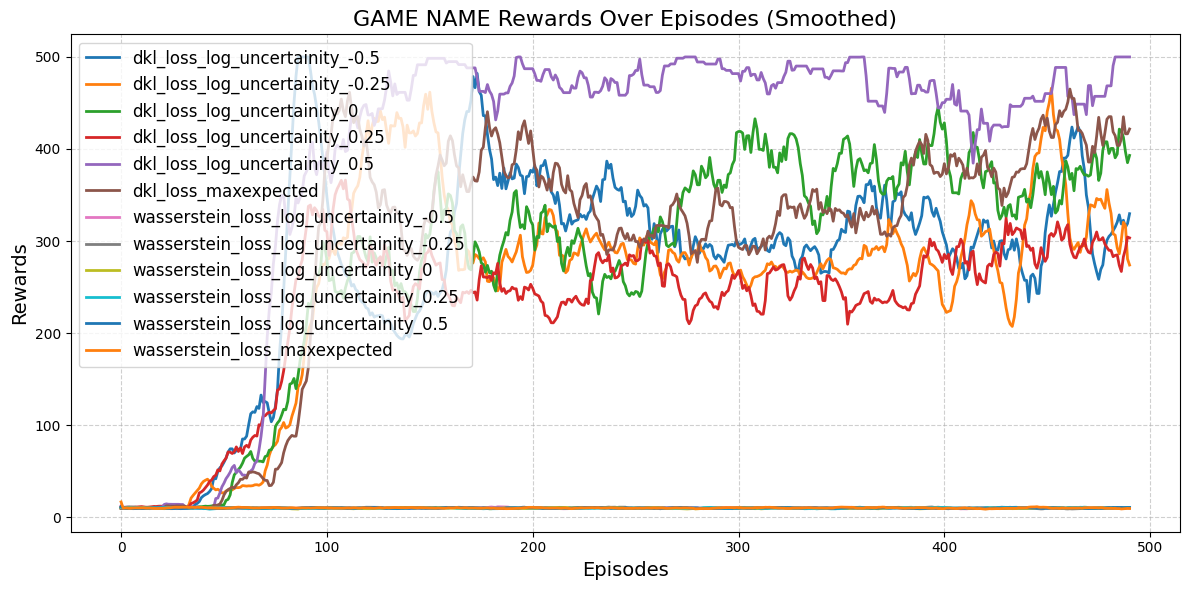

In [9]:
plot_improved_rewards(gameres)

In [15]:
utils.av

<module 'utils' from '/Users/potty/Desktop/projects/fyp/src/utils.py'>

In [8]:
[1,2,3][0:]

[1, 2, 3]

In [37]:

def ensemble_experiment(
    env_name: str,
    episodes: int,
    num_ensemble: int = 5,
    hidden_dim: int = 64,
    num_runs: int = 1,
    GAMMA: float = 0.99,
    batch_size=128,
) -> dict:
    # Create environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    loss_configs = []
    # for upd in ["mle", "no_update", "mle_max_update"]:
    #     for use_min in [True, False]:
    #         name = f"td_ensemble_{upd}_min{use_min}"
    #         loss_fn = td_loss_ensemble(
    #             GAMMA=GAMMA,
    #             ALPHA=0.9,
    #             normalise=False,
    #             possibility_update=upd,
    #             use_ensemble_min=use_min,
    #         )
    #         loss_configs.append((loss_fn, name))

    # for upd in ["mle", "mle_max_update"]:
    #     for use_min in [True, False]:
    #         for beta in [0.1, 0.01]:
    #             name = f"td_ensemble_grad_{upd}_min{use_min}_beta{beta}"
    #             loss_fn = td_loss_ensemble_grad_updated2(
    #                 GAMMA=GAMMA,
    #                 BETA=beta,
    #                 ALPHA=0.99,
    #                 possibility_update=upd,
    #                 use_ensemble_min=use_min,
    #             )
    #             loss_configs.append((loss_fn, name))

    for beta in [0.1, 0.01]:
        for alpha in [0.2, 0.1]:
            name = f"td_ensemble_grad_beta{beta}_alpha{1-alpha}"
            loss_fn = td_loss_ensemble_grad(
                GAMMA=GAMMA,
                BETA=beta,
                ALPHA=alpha,
                normalise = False
            )
            loss_configs.append((loss_fn, name))
   


    # 2) Action selection methods
    action_methods = [
        (ensemble_action_weighted_sum(action_dim), "weighted_sum"),
        (ensemble_action_majority_voting(action_dim), "majority_vote"),
    ]

    results = {}

    configs = {
        "action_dim": action_dim,
        "state_dim": state_dim,
        "episodes": episodes,
        "batch_size": batch_size,
        "eps": 0.1,
        "tau_soft_update": 0.05,
        "update_steps": 5,
    }

    # 3) Run experiments
    for loss_fn, loss_name in loss_configs:
        for act_fn, act_name in action_methods:
            combo = f"{loss_name}_{act_name}"
            all_rewards = []

            for run in range(num_runs):
                print(f"Running {combo}, run {run + 1}/{num_runs}")

                # Instantiate ensembles
                online_qnet = EnsembleDQN(
                    state_dim,
                    action_dim,
                    num_ensemble=num_ensemble,
                    hidden_dim=hidden_dim,
                ).to(DEVICE)
                target_qnet = EnsembleDQN(
                    state_dim,
                    action_dim,
                    num_ensemble=num_ensemble,
                    hidden_dim=hidden_dim,
                ).to(DEVICE)
                hard_target_update(online_qnet, target_qnet)

                # One optimizer per member
                optimizers = [
                    optim.Adam(q.parameters(), lr=1e-3) for q in online_qnet.qnets
                ]

                buffer = ReplayBuffer(capacity=100000)

                rewards = training_loop_qn(
                    env=env,
                    online_qnet=online_qnet,
                    target_qnet=target_qnet,
                    optimizers=optimizers,
                    td_lossfunc=loss_fn,
                    select_action=act_fn,
                    replay_buffer=buffer,
                    configs=configs,
                    print_info=False,
                    discrete=True,
                )
                all_rewards.append(rewards)
                print(max(rewards))

            results[combo] = all_rewards

    return results


In [38]:
results3 = ensemble_experiment("CartPole-v1", episodes = 1000, batch_size = 1024, num_runs= 1)

Running td_ensemble_grad_beta0.1_alpha0.2_weighted_sum, run 1/1
500.0
Running td_ensemble_grad_beta0.1_alpha0.2_majority_vote, run 1/1
500.0
Running td_ensemble_grad_beta0.1_alpha0.1_weighted_sum, run 1/1
500.0
Running td_ensemble_grad_beta0.1_alpha0.1_majority_vote, run 1/1
500.0
Running td_ensemble_grad_beta0.01_alpha0.2_weighted_sum, run 1/1
500.0
Running td_ensemble_grad_beta0.01_alpha0.2_majority_vote, run 1/1
500.0
Running td_ensemble_grad_beta0.01_alpha0.1_weighted_sum, run 1/1
500.0
Running td_ensemble_grad_beta0.01_alpha0.1_majority_vote, run 1/1
447.0


list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
Plot saved as: GAME NAME_rewards_plot_20250417_220851.png


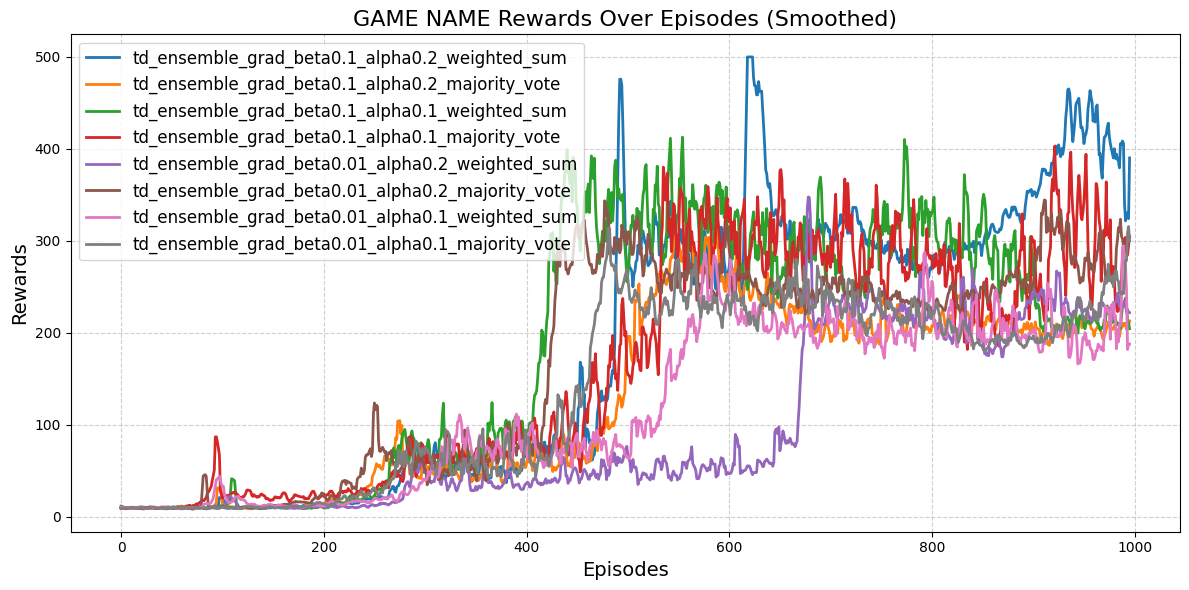

In [41]:
gameres = utils.avg_results(results3)
plot_improved_rewards(gameres, 5)

In [182]:
minq = 0.0
maxq = 4.0
numatoms = 10
[(minq + x*(maxq-minq)/(numatoms-1)) for x in range(numatoms)] 

[0.0,
 0.4444444444444444,
 0.8888888888888888,
 1.3333333333333333,
 1.7777777777777777,
 2.2222222222222223,
 2.6666666666666665,
 3.111111111111111,
 3.5555555555555554,
 4.0]

In [257]:
import numpy as np, random, pandas as pd

# ---------------------------------------------------------
# Hyper‑parameters
# ---------------------------------------------------------
minq = 0.0
maxq = 4.0
numatoms = 3
atoms  = np.array([(minq + x*(maxq-minq)/(numatoms-1)) for x in range(numatoms)] )   # fixed support
gamma  = 0.5                      # discount
sigma  = 0.6                    # Gaussian width for compatibilities
                  # number of env steps to simulate

# deterministic transition and reward tables
reward = {(0,'stay'): 0.75, (0,'switch'): 0,
          (1,'stay'): 2, (1,'switch'): 0}
next_s = {(0,'stay'): 0, (0,'switch'): 1,
          (1,'stay'): 1, (1,'switch'): 0}

# ---------------------------------------------------------
# Core routines
# ---------------------------------------------------------
def compat_matrix(target_atoms):
    """L_{jk} using a Gaussian kernel."""
    return np.exp(-((atoms[:,None] - target_atoms[None,:])**2) /
                  (2*sigma**2))

def possibilistic_update(f_prev, r):
    """One possibilistic Bellman update for a single (s,a,r,s')."""
    targets = r + gamma*atoms                 # T_k = r + γ q_k
    L       = compat_matrix(targets)          # J×K compatibility
    p_next  = f_prev / f_prev.sum()           # treat as probabilities
    ell     = (p_next * L).sum(1)             # aggregated support
    f_new   = ell / (ell.max()+0.0001)                 # sup‑normalise
    return f_new

def optimistic_Q(f):
    """Defuzzification: max_{j} q_j * f_j."""
    return np.max(atoms * f)
def plot_possibilities(f_dict, step=None):
    titles = {(0,'stay'):'(s=0, stay)',   (0,'switch'):'(s=0, switch)',
              (1,'stay'):'(s=1, stay)',   (1,'switch'):'(s=1, switch)'}
    fig, axs = plt.subplots(2,2, figsize=(8,6), sharey=True)
    for idx,(key,title) in enumerate(titles.items()):
        row, col = divmod(idx,2)
        poss = f_dict[key]
        axs[row,col].bar(atoms, poss, width=1.2, color='tab:orange')
        axs[row,col].set_title(title, fontsize=10)
        axs[row,col].set_xticks([0,1,2,3,4])
        axs[row,col].set_ylim(0,1.05)
    fig.suptitle(f'Possibility Distributions after step {step}', fontsize=14)
    plt.tight_layout()
    plt.show()
# ---------------------------------------------------------
# Initialise possibility tables  f[(s,a)] = [1,1,1]
# ---------------------------------------------------------
f = { (s,a): np.ones(len(atoms)) for s in (0,1) for a in ('stay','switch') }

log = []
state = 0



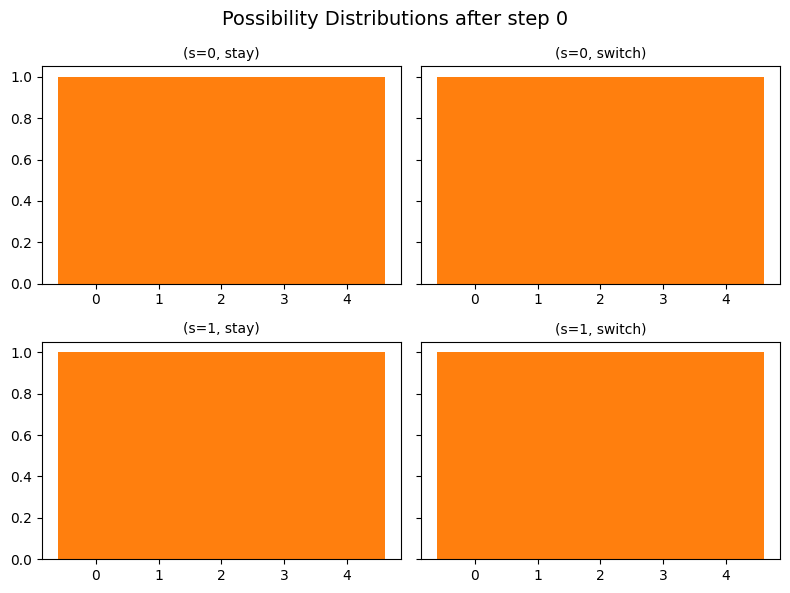

0 ['stay', 'switch']
0 ['stay']
1 ['stay', 'switch']
0 ['switch']
1 ['switch']
0 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
0 ['switch']
0 ['switch']
1 ['switch']
0 ['stay']
1 ['stay']
0 ['switch']
0 ['switch']
1 ['switch']
0 ['switch']
0 ['switch']
1 ['stay']
0 ['switch']
0 ['switch']
0 ['switch']
0 ['switch']
1 ['switch']
1 ['switch']
1 ['switch']
1 ['switch']
0 ['switch']
0 ['switch']
1 ['switch']
0 ['switch']
0 ['switch']
0 ['switch']
1 ['switch']
0 ['switch']
0 ['switch']
0 ['switch']
1 ['switch']
0 ['switch']
1 ['stay']
0 ['stay']
0 ['stay']
1 ['switch']
1 ['switch']
0 ['stay']
0 ['stay']
1 ['switch']
0 ['stay']
1 ['stay']


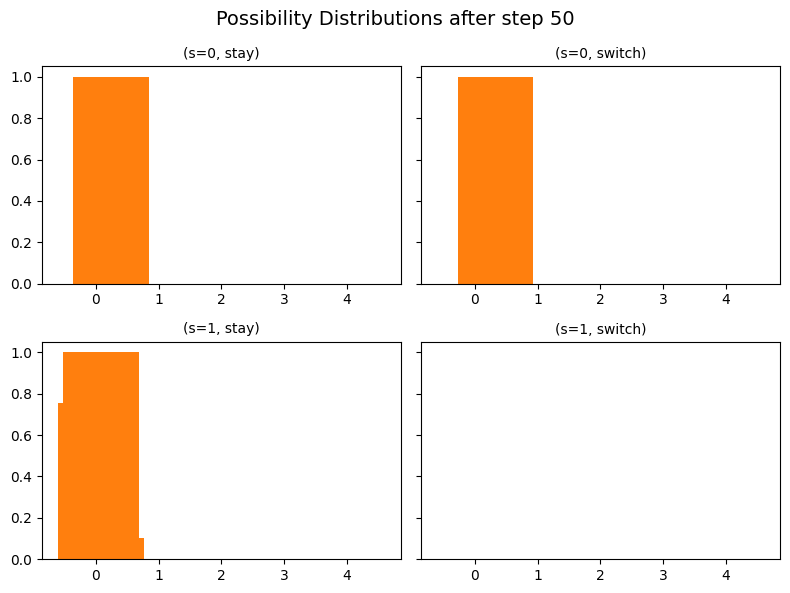

0 ['switch']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['switch']
1 ['switch']
1 ['switch']
0 ['switch']
0 ['stay']
1 ['switch']
1 ['stay']
0 ['stay']
1 ['stay']
0 ['switch']
1 ['stay']
0 ['switch']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay', 'switch']
0 ['stay']
1 ['switch']
1 ['switch']
1 ['stay', 'switch']
1 []


/var/folders/dm/bf8cjc0d25n75cy02jj4ms940000gn/T/ipykernel_86223/2101648598.py:32: RuntimeWarning: invalid value encountered in divide
  p_next  = f_prev / f_prev.sum()           # treat as probabilities


IndexError: list index out of range

In [267]:
minq = 0.0
maxq = 4.0
numatoms = 50
atoms  = np.array([(minq + x*(maxq-minq)/(numatoms-1)) for x in range(numatoms)] )   # fixed support
gamma  = 0.5                      # discount
sigma  = 1  
# Gaussian width for compatibilities
reward = {(0,'stay'): 0.75, (0,'switch'): 0,
          (1,'stay'): 2, (1,'switch'): 0}
next_s = {(0,'stay'): 0, (0,'switch'): 1,
          (1,'stay'): 1, (1,'switch'): 0}
f = { (s,a): np.ones(len(atoms)) for s in (0,1) for a in ('stay','switch') }

log = []
state = 0

for t in range(200):
    # pick action by optimistic value (ties -> random)
    if t%50 == 0: plot_possibilities(f, step=t)
    Q_vals = {a: optimistic_Q(f[(state,a)]) for a in ('stay','switch')}
    sigma  *= 0.9 
    max_Q  = max(Q_vals.values())
    best   = [a for a,q in Q_vals.items() if q == max_Q]
    print(state, best)
    
    #action = random.choice(["stay", "switch"]) 
    action = random.choice(best) # tie‑break
    # record before update
    log.append(dict(t=t, state=state, action=action,
                    Q_stay=Q_vals['stay'], Q_switch=Q_vals['switch']))
    # environment step
    actiont = random.choice(["stay", "switch"]) 
    r      = reward[(state,actiont)]
    s_next = next_s[(state,actiont)]
    # update only the (state,action) we just experienced
    f[(state,action)] = possibilistic_update(f[(state,action)], r)
    # move to next state
    state = s_next


# ---------------------------------------------------------
# Pretty‑print the trajectory
# ---------------------------------------------------------
df = pd.DataFrame(log)
print(df.to_string(index=False))


0 ['stay']
 t  state action   Q_stay  Q_switch
40      0   stay 4.000000  4.000000
41      0 switch 2.582204  4.000000
42      1   stay 4.000000  4.000000
43      1 switch 3.623289  4.000000
44      0   stay 2.582204  1.752271
45      0   stay 2.271977  1.752271
46      0   stay 2.292982  1.752271
47      0   stay 2.315789  1.752271
48      0   stay 2.315789  1.752271
49      0   stay 2.315789  1.752271
50      0   stay 2.315789  1.752271
51      0   stay 2.315789  1.752271
52      0   stay 2.315789  1.752271
53      0   stay 2.315789  1.752271
54      0   stay 2.315789  1.752271
55      0   stay 2.315789  1.752271
{'stay': np.float64(2.3157894736842106), 'switch': np.float64(1.7522713905891791)}


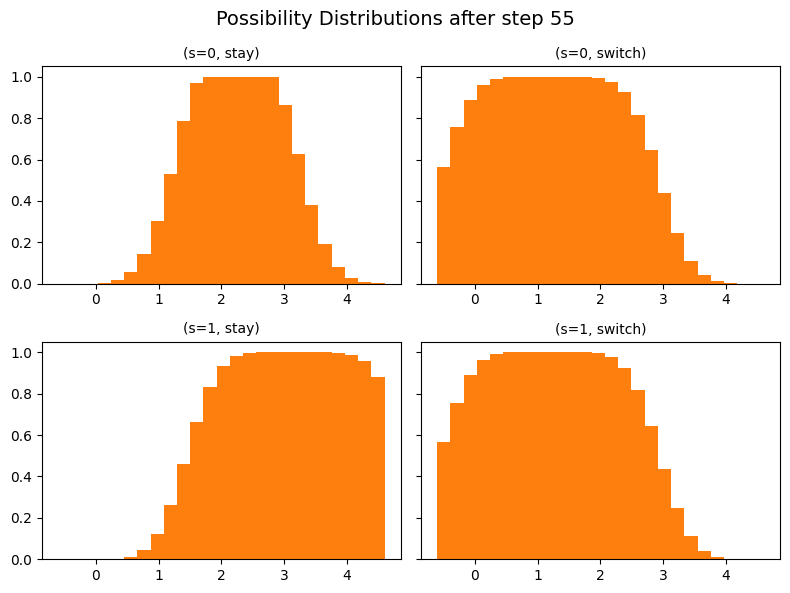

{(0, 'stay'): array([4.03187475e-05, 2.46205740e-04, 1.25656972e-03, 5.36641718e-03,
       1.91880461e-02, 5.74546448e-02, 1.44080386e-01, 3.02609406e-01,
       5.32305967e-01, 7.84227048e-01, 9.67659208e-01, 1.00000000e+00,
       8.65502021e-01, 6.27354024e-01, 3.80803504e-01, 1.93532538e-01,
       8.23169344e-02, 2.92761128e-02, 8.69078832e-03, 2.14676572e-03]), (0, 'switch'): array([5.63966849e-01, 7.55290097e-01, 8.89469352e-01, 9.61090574e-01,
       9.90164893e-01, 9.98982901e-01, 1.00000000e+00, 9.95169215e-01,
       9.76422223e-01, 9.24809901e-01, 8.16950180e-01, 6.45412713e-01,
       4.37766683e-01, 2.46443428e-01, 1.12264033e-01, 4.06408194e-02,
       1.15450299e-02, 2.55093523e-03, 4.35671404e-04, 5.72558783e-05]), (1, 'stay'): array([5.81943327e-07, 7.34641032e-06, 7.09688105e-05, 5.25962867e-04,
       3.00063161e-03, 1.32390864e-02, 4.54675210e-02, 1.22664689e-01,
       2.63391484e-01, 4.58647911e-01, 6.64857672e-01, 8.30622390e-01,
       9.32045517e-01, 9.792687

In [227]:
t = t+1 
Q_vals = {a: optimistic_Q(f[(state,a)]) for a in ('stay','switch')}
max_Q  = max(Q_vals.values())
best   = [a for a,q in Q_vals.items() if q == max_Q]
print(state, best)

action = random.choice(best)   
action = 'stay'# tie‑break
# record before update
log.append(dict(t=t, state=state, action=action,
                Q_stay=Q_vals['stay'], Q_switch=Q_vals['switch']))
# environment step
r      = reward[(state,action)]
s_next = next_s[(state,action)]
# update only the (state,action) we just experienced
f[(state,action)] = possibilistic_update(f[(state,action)], r)
# move to next state
state = s_next

df = pd.DataFrame(log)
print(df.to_string(index=False))
print({a: optimistic_Q(f[(state,a)]) for a in ('stay','switch')})
plot_possibilities(f, step=t)
print(f)

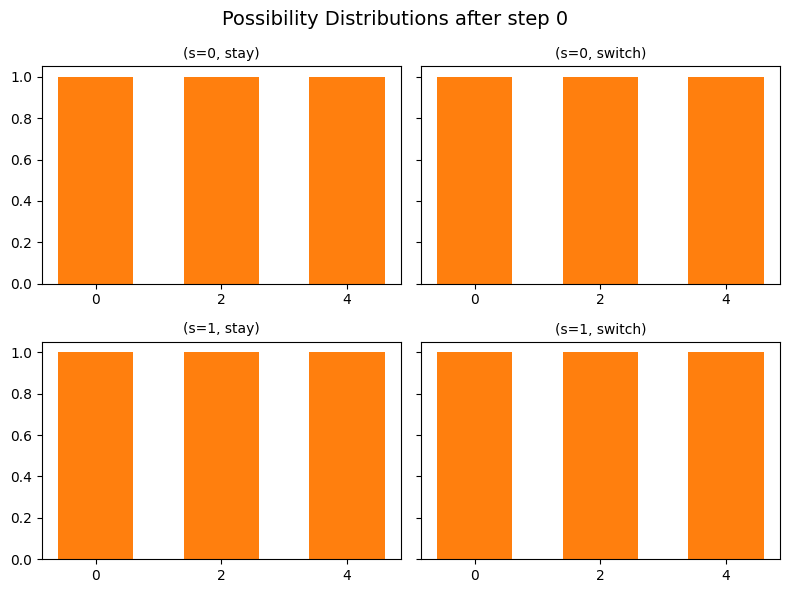

0 ['stay', 'switch']
0 ['switch']
0 ['switch']
1 ['stay', 'switch']
1 ['stay', 'switch']
1 ['stay', 'switch']
0 ['stay', 'switch']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']


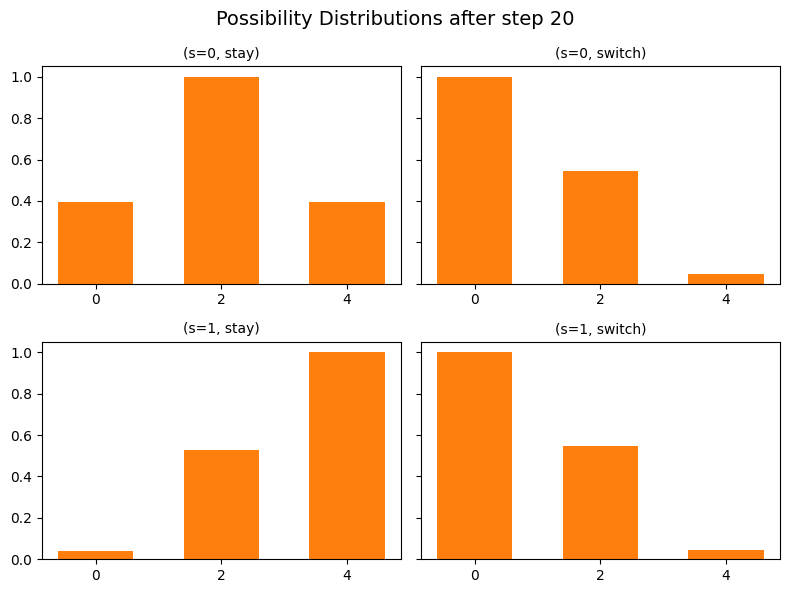

0 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']


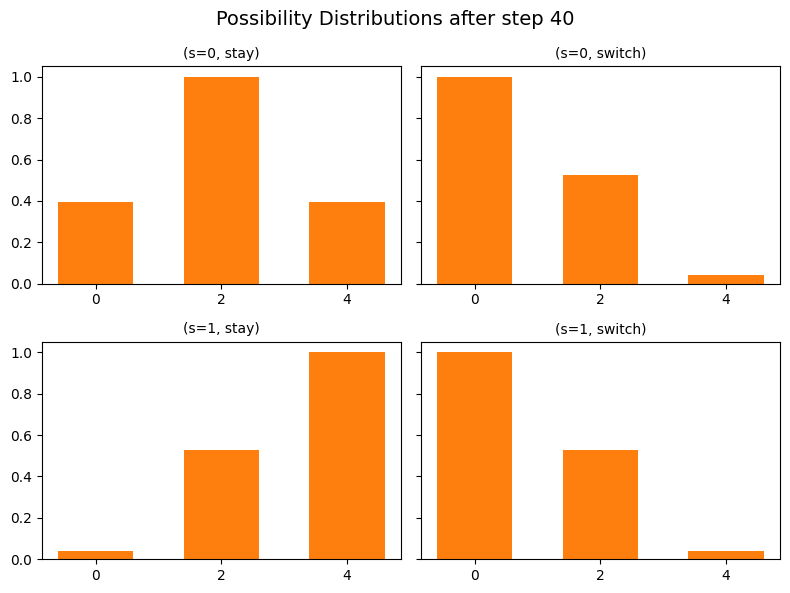

0 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']


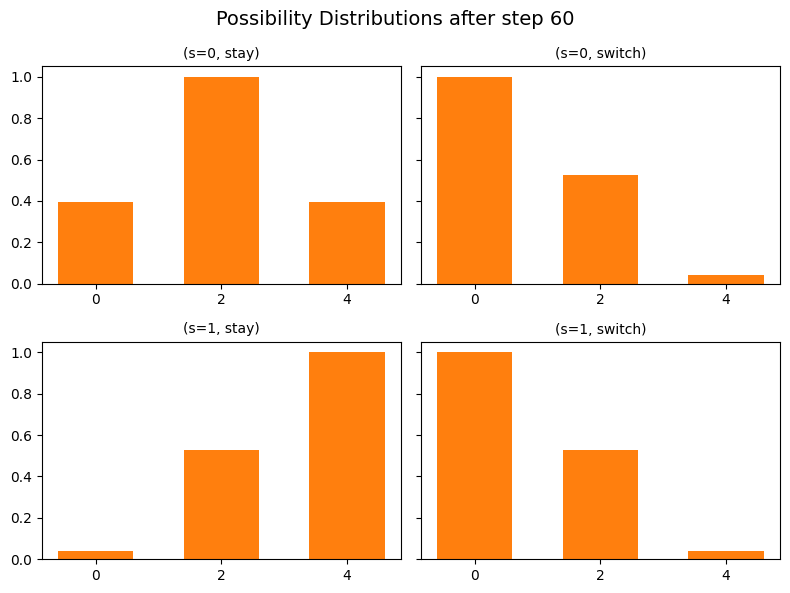

0 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']


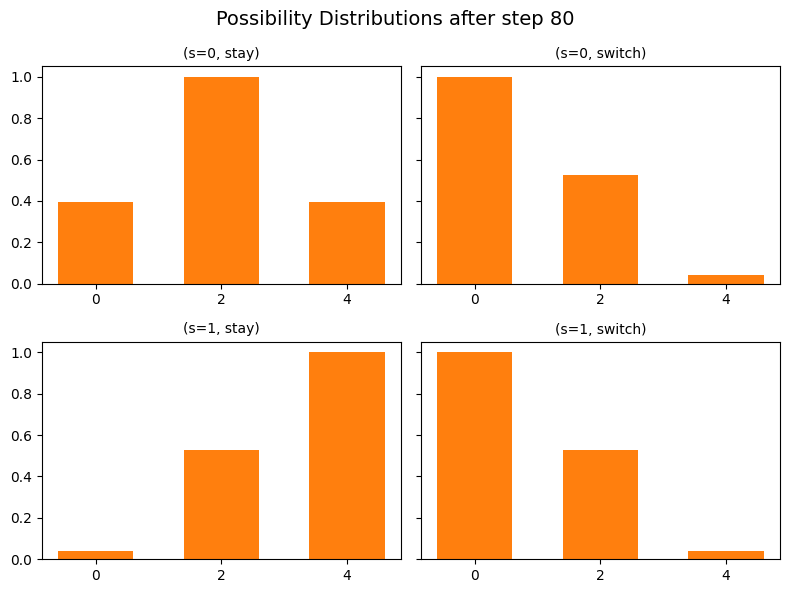

1 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']


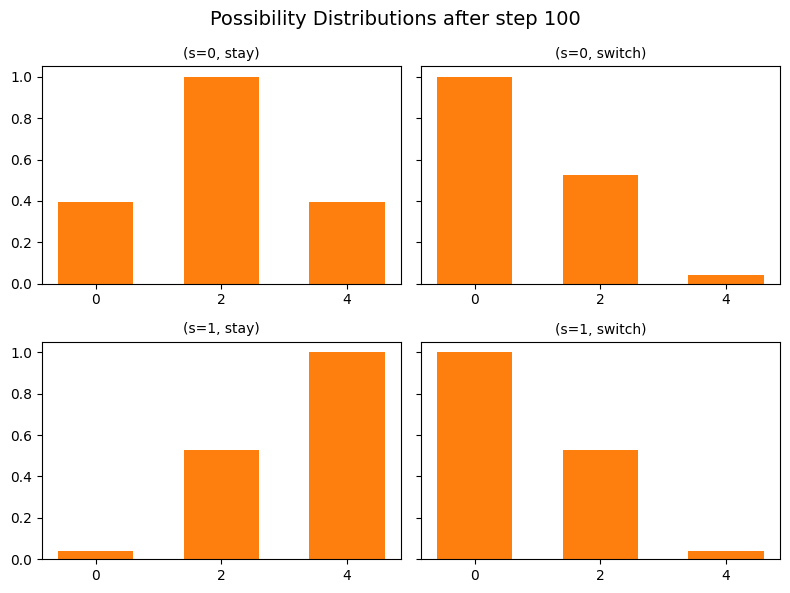

0 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']


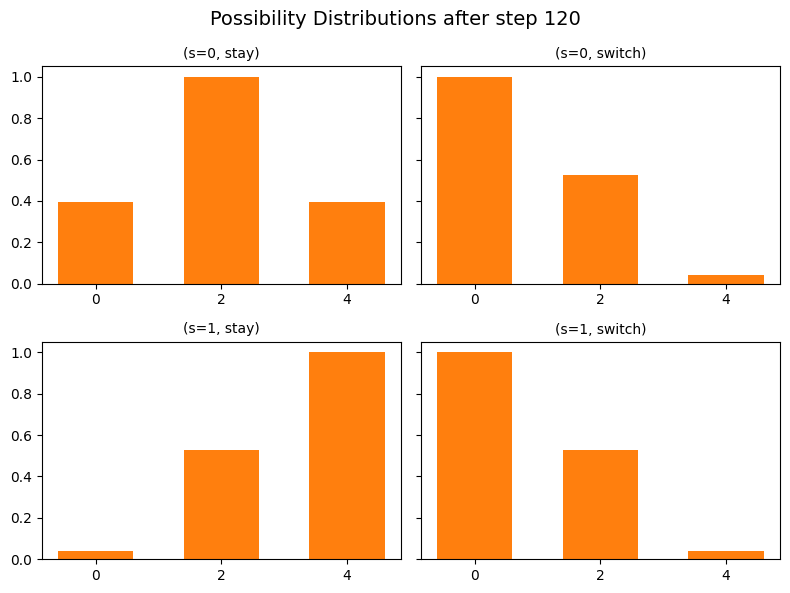

1 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']


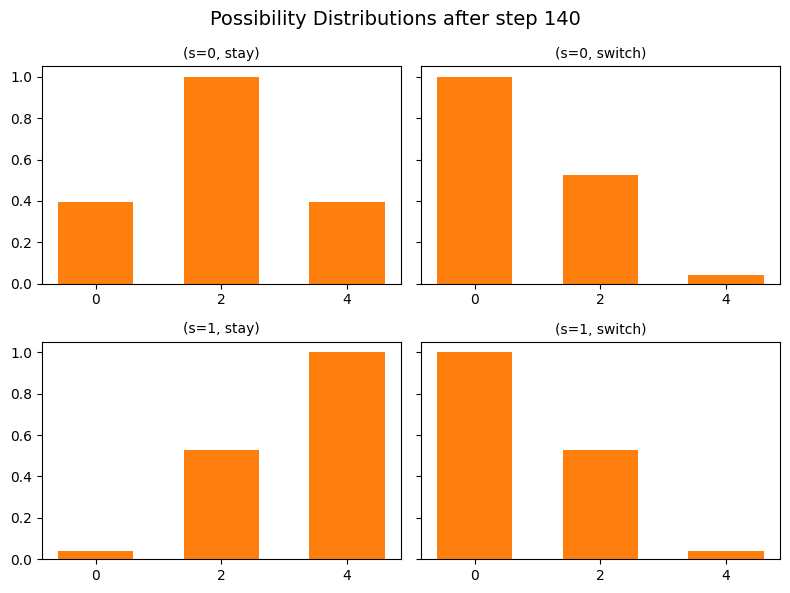

1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']


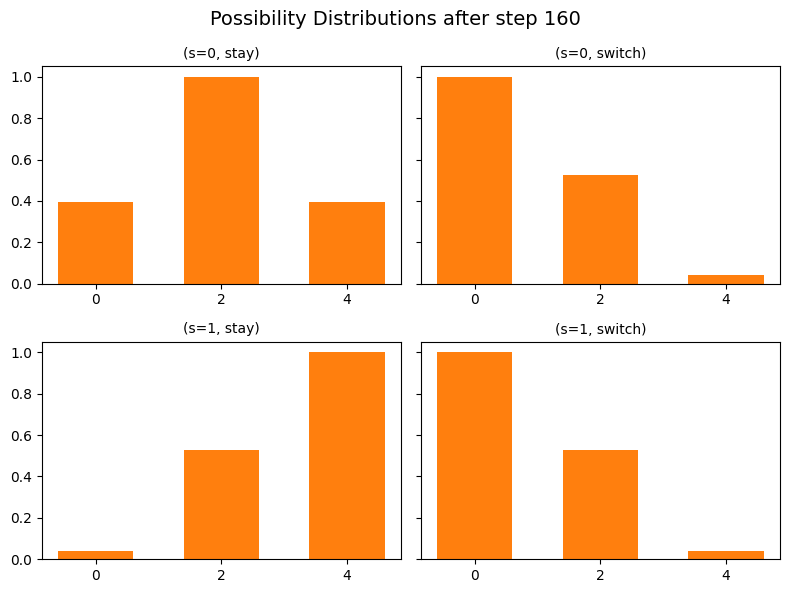

1 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']


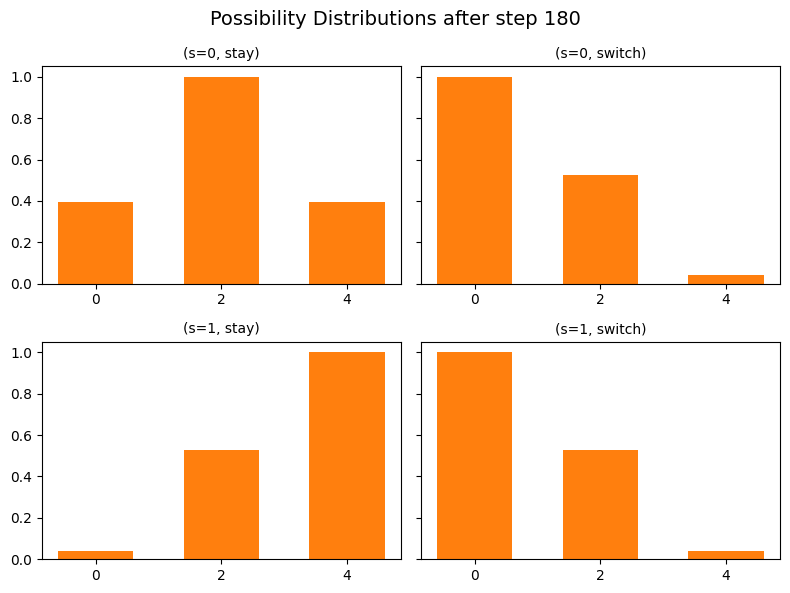

1 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
0 ['stay']
1 ['stay']
1 ['stay']
1 ['stay']
0 ['stay']
  t  state action  Q_stay  Q_switch
  0      0   stay     4.0  4.000000
  1      0   stay     2.0  4.000000
  2      0 switch     2.0  4.000000
  3      1   stay     4.0  4.000000
  4      1   stay     4.0  4.000000
  5      1 switch     4.0  4.000000
  6      0 switch     2.0  2.000000
  7      1   stay     4.0  2.000000
  8      1   stay     4.0  2.000000
  9      1   stay     4.0  2.000000
 10      1   stay     4.0  2.000000
 11      1   stay     4.0  2.000000
 12      1   stay     4.0  2.000000
 13      1 switch     4.0  2.000000
 14      0   stay     2.0  1.374295
 15      0   stay     2.0  1.374295
 16      0 switch     2.0  1.374295
 17      1 switch     4.0  1.374295
 18      0 switch     2.0  1.163931
 19      1 switch     4.0  1.163931
 20      0 switch     2.

In [178]:
for t in range(200):
    # pick action by optimistic value (ties -> random)
    if t%20 == 0: plot_possibilities(f, step=t)
    Q_vals = {a: optimistic_Q(f[(state,a)]) for a in ('stay','switch')}
    max_Q  = max(Q_vals.values())
    best   = [a for a,q in Q_vals.items() if q == max_Q]
    print(state, best)
    
    action = random.choice(["stay", "switch"])              # tie‑break
    # record before update
    log.append(dict(t=t, state=state, action=action,
                    Q_stay=Q_vals['stay'], Q_switch=Q_vals['switch']))
    # environment step
    r      = reward[(state,action)]
    s_next = next_s[(state,action)]
    # update only the (state,action) we just experienced
    f[(state,action)] = possibilistic_update(f[(state,action)], r)
    # move to next state
    state = s_next


# ---------------------------------------------------------
# Pretty‑print the trajectory
# ---------------------------------------------------------
df = pd.DataFrame(log)
print(df.to_string(index=False))

 t  state action   Q_stay  Q_switch
11      0   stay 4.000000  4.000000
11      0 switch 2.223963  4.000000
11      1   stay 4.000000  4.000000
11      1   stay 3.000000  4.000000
11      1 switch 3.693619  4.000000
11      0   stay 2.223963  1.482642
11      0 switch 2.061748  1.482642
11      1   stay 3.693619  1.482642
11      1   stay 4.000000  1.482642
11      1   stay 4.000000  1.482642


In [ ]:
env: gym.Env = make_env(id=env_name)
env_name += "_noisy"
# env: gym.Env = gym.make(env_name, render_mode="rgb_array")
# env: gym.Env = gym.make(env_name, render_mode="rgb_array")
experimental_results = {}

next_state_sample_l = "gaussian"
[
    "null",
    "gaussian",
    "triangular",
    "unif",
]
    
replay_buffer = ReplayBuffer(capacity=100000)

state_dim: int = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

online_actor = Actor(state_dim, action_dim).to(device)
online_critic = SimpleCritic(state_dim, action_dim).to(device)
target_actor = Actor(state_dim, action_dim).to(device)
target_critic = SimpleCritic(state_dim, action_dim).to(device)
target_actor.load_state_dict(online_actor.state_dict())
target_critic.load_state_dict(online_critic.state_dict())

actor_optimizer = optim.Adam(online_actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(online_critic.parameters(), lr=1e-3)

select_action_func = AC_SelectAction(action_dim=action_dim)
# loss_func = actor_critic_loss(
#     state_dim=state_dim,
#     action_dim=action_dim,
#     batch_size=256,
#     gamma=0.99,
# )
loss_func = ActorCriticLossMaxMax(
    state_dim=state_dim,
    action_dim=action_dim,
    batch_size=256,
    gamma=0.99,
    num_next_state_sample=5,
    next_state_sample=next_state_sample,
    rollout_depth = 0, 
    use_min=False,
)
configs = {
    "action_dim": action_dim,
    "state_dim": state_dim,
    "episodes": 1000,
    "eps": 0.1,
    "tau_soft_update": 0.05,
}

rewards = training_loop_ac(
    env=env,
    select_action_func=select_action_func,
    loss_func=loss_func,
    online_actor=online_actor,
    target_actor=target_actor,
    actor_optimizer=actor_optimizer,
    online_critic=online_critic,
    target_critic=target_critic,
    critic_optimizer=critic_optimizer,
    configs=configs,
    print_info=True,
    quantile_models=quantile_models,
    quantile_optimizers=quantile_optimizers,
)
